In [4]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

In [5]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'
city = 'Guadalajara'
type_area = 'urban'

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' AND \"type\" = \'{type_area}\'"

hex_gdf = aup.gdf_from_query(query)
hex_gdf = hex_gdf.set_crs("EPSG:4326")
print(hex_gdf.shape)
hex_gdf.head(2)

(6540, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban


### Area of Interest

In [12]:
aoi_gdf = gpd.read_file('../../../data/processed/viviendas_tlajo/AOI_Viviendas_Tlajo.geojson')
aoi_gdf = aoi_gdf.to_crs("EPSG:32613")
print(aoi_gdf.shape)
aoi_gdf.head(1)

(106, 11)


,hex_id,CVEGEO,NOMGEO,city,type,pct_BANQUETA,pct_ALUMPUB,pct_RAMPAS,pct_ARBOLES,pct_CICLOVIA,geometry
0,8949aa2ea37ffff,14097,Tlajomulco de Zúñiga,Guadalajara,urban,0.438522,0.43849,0.299607,0.402497,0.0,"POLYGON ((668991.147 2270868.529, 669116.373 2..."


Buffer from AOI

In [13]:
aoi_buffer = aoi_gdf.copy()
aoi_buffer = aoi_buffer.dissolve()
aoi_buffer['geometry'] = aoi_buffer.buffer(500)
print(aoi_buffer.shape)

(1, 11)


### Nodes, edges

In [14]:
aoi_buffer = aoi_buffer.to_crs("EPSG:4326")

G,nodes,edges = aup.graph_from_hippo(aoi_buffer, schema='osmnx', 
                    edges_folder='edges_speed_23_line', nodes_folder='nodes_osmnx_23_point')
print('nodes:',nodes.shape,'edges:',edges.shape)

nodes: (5291, 5) edges: (12386, 19)


### Rutas de transporte público

In [6]:
rutas_gdf = gpd.read_file('../../../data/processed/viviendas_tlajo/transporte_publico/rutas_tp_gdl.geojson')
print(rutas_gdf.shape)
rutas_gdf.head(2)

(670, 6)


,Tipo_de_se,Clasificac,Clasifica0,layer,path,geometry
0,"T 05, L�pez Mateos",Corredores troncales,Presentadas en grupo de Trabajo,vwCorredores_troncales_mapa_base_mayo_2021,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,"MULTILINESTRING ((661387.867 2270907.072, 6613..."
1,"T 05, L�pez Mateos",Corredores troncales,Presentadas en grupo de Trabajo,vwCorredores_troncales_mapa_base_mayo_2021,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,"MULTILINESTRING ((666791.399 2284313.859, 6667..."


### Ciclovías

In [7]:
ciclista_gdf = gpd.read_file('../../../data/processed/viviendas_tlajo/transporte_publico/ciclovias_mibici_gdl.geojson')
print(ciclista_gdf.shape)
ciclista_gdf.head(2)

(5803, 24)


/home/edgaregurrola/.cache/pypoetry/virtualenvs/aup-qDsIK5d5-py3.11/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 2 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


,fid,cat,Nombre_de_,Municipio,Ao__o_de_c,Ao__o_de_r,Tipo_de_di,Tipo_de_ci,vertex_pos,vertex_ind,...,id,name,obcn,location,latitude,longitude,status,layer,path,geometry
0,1.0,1.0,Prolongaci�n Laureles,Zapopan,2019,N/A,Unidireccional,Confinada,0.0,0.0,...,NaN,None,None,None,NaN,NaN,None,ciclovias_vertex,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,POINT (668155.05 2293313.298)
1,1.0,1.0,Prolongaci�n Laureles,Zapopan,2019,N/A,Unidireccional,Confinada,-1.0,1.0,...,NaN,None,None,None,NaN,NaN,None,ciclovias_vertex,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,POINT (668168.262 2293359.411)


### Paradas transporte público

In [8]:
tp_gdf = gpd.read_file('../../../data/processed/viviendas_tlajo/transporte_publico/paradas_tp_gdl.geojson')
tp_gdf = tp_gdf.explode()
tp_gdf = tp_gdf.to_crs("EPSG:4326")
print(tp_gdf.shape)
tp_gdf.head(2)

(12441, 11)


,Disponibil,Disponibli,Disponibi0,Disponibi1,Disponibi2,Vegetaci�n,Clasificac,Rutas_que_,Rutas_adic,Municipio,geometry
0,No,No,No,No,No,No,Parada convergente (2 o m�s rutas),"Troncal 13A Solidaridad, Troncal 13B Solidarid...",N/A,El Salto,POINT (-103.26406 20.54483)
1,No,No,No,No,No,No,Parada convergente (2 o m�s rutas),"Troncal 19 Perif�rico, C19, C46-V1, C46-V2, C106",N/A,Tonal�,POINT (-103.25837 20.61802)


### Paradas transporte público masivo

In [9]:
tp_masivo_gdf = gpd.read_file('../../../data/processed/viviendas_tlajo/transporte_publico/paradas_tp_masivo_gdl.geojson')
print(tp_masivo_gdf.shape)
tp_masivo_gdf.head(2)

(119, 6)


,Nombre_de_,Sistema,Estructura,Estado,L�nea_y_si,geometry
0,San Juan de Ocot�n,BRT (Bus Rapid Transit),Superficie,En proceso,Mi Macro Perif�rico,MULTIPOINT ((662315.284 2290788.242))
1,8 de Julio,BRT (Bus Rapid Transit),Superficie,En proceso,Mi Macro Perif�rico,MULTIPOINT ((668890.558 2276995.459))


## Proximity analysis

### Ciclista

In [28]:
ciclo_osmid = aup.find_nearest(G, nodes, ciclista_gdf, return_distance= True)
ciclo_osmid = ciclo_osmid.loc[ciclo_osmid.distance_node<=200].copy()
print(ciclo_osmid.shape)

(0, 26)


In [17]:
nodes_ciclo = aup.calculate_distance_nearest_poi(ciclo_osmid, nodes, 
                                                     edges, 'ciclo', 'osmid', wght='time_min')
nodes_ciclo = nodes_ciclo.reset_index()
nodes_ciclo.head(4)

,osmid,x,y,street_count,geometry,city,dist_ciclo
0,1675924421,-103.378025,20.521124,1,POINT (-103.37803 20.52112),Guadalajara,37.319188
1,1750578918,-103.379185,20.510326,3,POINT (-103.37919 20.51033),Guadalajara,49.892291
2,1750578919,-103.379075,20.510316,3,POINT (-103.37907 20.51032),Guadalajara,49.758571
3,1750578932,-103.369503,20.511927,4,POINT (-103.3695 20.51193),Guadalajara,43.858227


### Transporte público

In [29]:
tp_osmid = aup.find_nearest(G, nodes, tp_gdf, return_distance= True)
tp_osmid = tp_osmid.loc[tp_osmid.distance_node<=200].copy()
print(tp_osmid.shape)

(262, 13)


In [30]:
nodes_tp = aup.calculate_distance_nearest_poi(tp_osmid, nodes, 
                                                     edges, 'tp', 'osmid', wght='time_min')
nodes_tp = nodes_tp.reset_index()
nodes_tp.head(4)

,osmid,x,y,street_count,geometry,city,dist_tp
0,1675924421,-103.378025,20.521124,1,POINT (-103.37803 20.52112),Guadalajara,4.399859
1,1750578918,-103.379185,20.510326,3,POINT (-103.37919 20.51033),Guadalajara,4.372189
2,1750578919,-103.379075,20.510316,3,POINT (-103.37907 20.51032),Guadalajara,4.199059
3,1750578932,-103.369503,20.511927,4,POINT (-103.3695 20.51193),Guadalajara,0.000000


<Axes: >

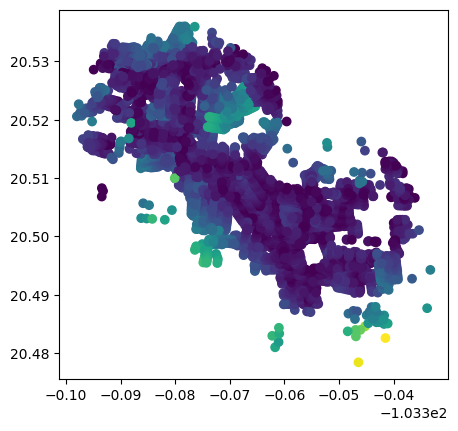

In [31]:
nodes_tp.plot('dist_tp')

### Transporte público masivo

In [21]:
tp_masivo_gdf = tp_masivo_gdf.explode() 

In [32]:
tpm_osmid = aup.find_nearest(G, nodes, tp_masivo_gdf, return_distance= True)
tpm_osmid = tpm_osmid.loc[tpm_osmid.distance_node<=200].copy()
print(tpm_osmid.shape)

(0, 8)


In [23]:
nodes_tpm = aup.calculate_distance_nearest_poi(tpm_osmid, nodes, 
                                                     edges, 'tpm', 'osmid', wght='time_min')
nodes_tpm = nodes_tpm.reset_index()
nodes_tpm.head(4)

,osmid,x,y,street_count,geometry,city,dist_tpm
0,1675924421,-103.378025,20.521124,1,POINT (-103.37803 20.52112),Guadalajara,37.319188
1,1750578918,-103.379185,20.510326,3,POINT (-103.37919 20.51033),Guadalajara,49.892291
2,1750578919,-103.379075,20.510316,3,POINT (-103.37907 20.51032),Guadalajara,49.758571
3,1750578932,-103.369503,20.511927,4,POINT (-103.3695 20.51193),Guadalajara,48.347098


<Axes: >

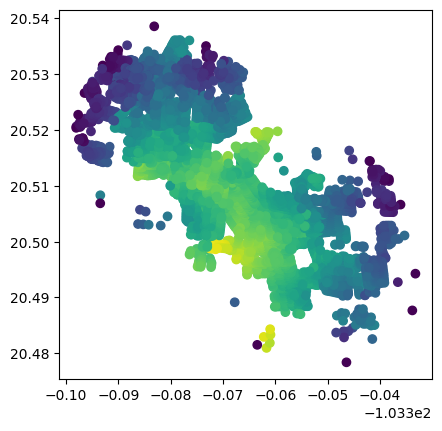

In [24]:
nodes_tpm.plot('dist_tpm')

### Número de rutas

In [45]:
hex_gdf = hex_gdf.to_crs("EPSG:32613")
rutas_hex = rutas_gdf.overlay(aoi_gdf[['hex_id','geometry']], how='intersection')
rutas_hex = rutas_hex.groupby('hex_id').count()
print(rutas_hex.shape)
rutas_hex.head(2)

(63, 6)


,Tipo_de_se,Clasificac,Clasifica0,layer,path,geometry
hex_id,,,,,,
8949aa2c4a7ffff,8,8,8,8,8,8
8949aa2c4b7ffff,2,2,2,2,2,2


In [46]:
rutas_hex = rutas_hex.reset_index()
rutas_hex = rutas_hex[['hex_id','geometry']].copy()
rutas_hex = rutas_hex.rename(columns={'geometry':'ruta_count'})

## Data to hex

<Axes: >

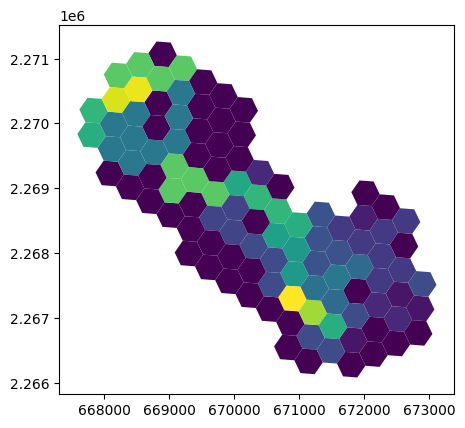

In [47]:
hex_connectivity = aoi_gdf[['hex_id','geometry']].merge(rutas_hex, on='hex_id', how='left')
hex_connectivity = hex_connectivity.fillna(0)
hex_connectivity.plot('ruta_count')

In [48]:
hex_connectivity.head(2)

,hex_id,geometry,ruta_count
0,8949aa2ea37ffff,"POLYGON ((668991.147 2270868.529, 669116.373 2...",0.0
1,8949aa2eac7ffff,"POLYGON ((670209.642 2269635.158, 670334.867 2...",0.0


In [42]:
nodes_ciclo = nodes_ciclo.to_crs("EPSG:32613")
hex_connectivity = proylib.group_by_hex_mean(nodes_ciclo, hex_connectivity, 9, 'dist_ciclo')
hex_connectivity = hex_connectivity.drop(columns=['index','x','y','street_count',
                                                 'elevation','ruta_count_y'])
hex_connectivity = hex_connectivity.rename(columns={'ruta_count_x':'ruta_count'})
print(hex_connectivity.shape)
hex_connectivity.head(2)

(1214, 8)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,ruta_count,dist_ciclo
0,89498c95c87ffff,"POLYGON ((677982.641 2291440.466, 678107.875 2...",14039,Guadalajara,Guadalajara,urban,0.0,93.868405
1,89498c94e8bffff,"POLYGON ((674042.522 2291745.980, 674167.759 2...",14039,Guadalajara,Guadalajara,urban,18.0,65.031282


<AxesSubplot: >

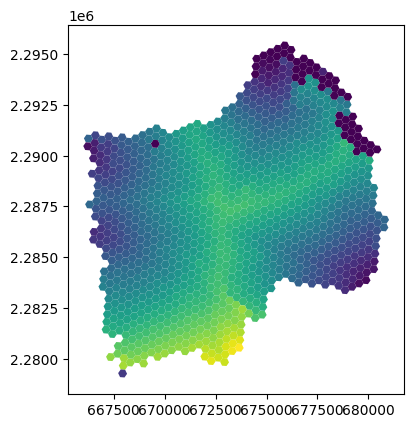

In [43]:
hex_connectivity.plot('dist_ciclo')

In [45]:
nodes_tp = nodes_tp.to_crs("EPSG:32613")
hex_connectivity = proylib.group_by_hex_mean(nodes_tp, hex_connectivity, 9, 'dist_tp')
hex_connectivity = hex_connectivity.drop(columns=['index','x','y','street_count',
                                                 'elevation','ruta_count_y','dist_ciclo_y'])
hex_connectivity = hex_connectivity.rename(columns={'ruta_count_x':'ruta_count',
                                                   'dist_ciclo_x':'dist_ciclo'})
print(hex_connectivity.shape)
hex_connectivity.head(2)

(1214, 9)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,ruta_count,dist_ciclo,dist_tp
0,89498c95c87ffff,"POLYGON ((677982.641 2291440.466, 678107.875 2...",14039,Guadalajara,Guadalajara,urban,0.0,93.868405,4.606166
1,89498c94e8bffff,"POLYGON ((674042.522 2291745.980, 674167.759 2...",14039,Guadalajara,Guadalajara,urban,18.0,65.031282,1.110908


<AxesSubplot: >

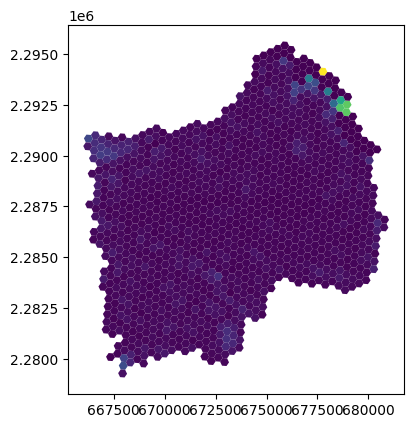

In [46]:
hex_connectivity.plot('dist_tp')

In [48]:
nodes_tpm = nodes_tpm.to_crs("EPSG:32613")
hex_connectivity = proylib.group_by_hex_mean(nodes_tpm, hex_connectivity, 9, 'dist_tpm')
hex_connectivity = hex_connectivity.drop(columns=['index','x','y','street_count',
                                                 'elevation','ruta_count_y','dist_ciclo_y',
                                                 'dist_tp_y'])
hex_connectivity = hex_connectivity.rename(columns={'ruta_count_x':'ruta_count',
                                                   'dist_ciclo_x':'dist_ciclo',
                                                   'dist_tp_x':'dist_tp'})
print(hex_connectivity.shape)
hex_connectivity.head(2)

(1214, 10)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,ruta_count,dist_ciclo,dist_tp,dist_tpm
0,89498c95c87ffff,"POLYGON ((677982.641 2291440.466, 678107.875 2...",14039,Guadalajara,Guadalajara,urban,0.0,93.868405,4.606166,93.868405
1,89498c94e8bffff,"POLYGON ((674042.522 2291745.980, 674167.759 2...",14039,Guadalajara,Guadalajara,urban,18.0,65.031282,1.110908,65.031282


<AxesSubplot: >

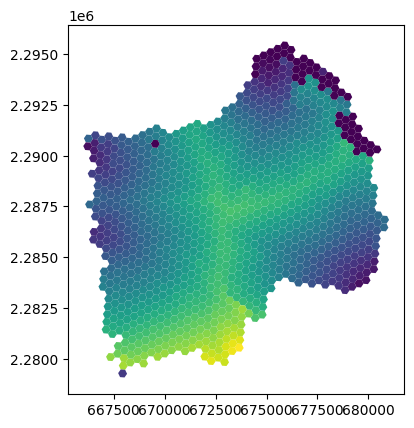

In [50]:
hex_connectivity.plot('dist_tpm')

In [51]:
hex_connectivity.to_file('../data/processed/hex_connectivity.geojson')